In [ ]:
# 19_deep_learning_hybrid.ipynb, deep learning hybrid(CNN + RNN) model overview

# 딥러닝 하이브리드 모델 개요
# 1. 하이브리드 구조 개념
# - CNN (Convolutional Neural Network): 이미지나 공간적 데이터를 처리하여 특징(feature)을 추출합니다.
# - RNN (Recurrent Neural Network) 또는 LSTM/GRU: 시계열적 특성을 가진 데이터를 처리하거나 CNN이 추출한 특징을 시퀀스로 간주해 순차적으로 처리합니다.

# 2. 대표적인 활용 예
# - 이미지 캡셔닝: CNN으로 이미지 특징 추출 → RNN으로 문장 생성
# - 비디오 분석: 프레임별 CNN 처리 → RNN으로 시간적 흐름 분석
# - 필기 인식: 이미지 → CNN → RNN → 텍스트 출력

# 3. 전체 로드맵 요약
# - 1단계 EMNIST : 목표(문자 분류), 모델 구조(CNN + RNN)
# - 2단계 IAM Handwriting : 목표(문자 예측), 모델 구조(CNN + RNN + CTC)
# - 3단계 UCF101 : 목표(액션 분류), 모델 구조(CNN + RNN)
# - 4단계 COCO Captions : 목표(이미지 캡셔닝), 모델 구조(CNN + RNN(텍스트 생성))

# 4. 대표적인 활용 데이터 셋 설명
# 1단계: EMNIST (문자 인식)
# - 데이터: 손글씨 알파벳 + 숫자 이미지
# - 목표: 단일 문자 분류
# - 모델 구조: CNN → RNN → Softmax 분류
# - 포인트:
# -   MNIST와 유사한 구조로 쉽게 확장 가능å
# -   다양한 클래스(숫자 + 알파벳)로 분류 성능 향상 실험 가능

# 2단계: IAM Handwriting (문장 인식)
# - 데이터: 실제 손글씨 문장 이미지 + 텍스트 라벨
# - 목표: 이미지 → 시퀀스 텍스트 예측
# - 모델 구조: CNN → RNN → CTC Loss 기반 시퀀스 예측
# - 포인트:
# -   CTC (Connectionist Temporal Classification) 사용
# -   OCR 기반 모델 설계 경험 가능
# -   전처리 중요: 이미지 정규화, 라벨 토큰화

# 3단계: UCF101 (비디오 액션 분류)
# - 데이터: 101가지 액션이 담긴 짧은 비디오 클립
# - 목표: 비디오 → 액션 분류
# - 모델 구조: CNN (프레임별) → RNN (시간 흐름) → 분류
# - 포인트:
# -   프레임 추출 + CNN 처리 → 시퀀스 입력
# -   Temporal dynamics 학습
# -   3D CNN 또는 2D CNN + RNN 조합 실험 가능

# 4단계: COCO Captions (이미지 캡셔닝)
# - 데이터: 이미지 + 캡션 텍스트
# - 목표: 이미지 → 문장 생성
# - 모델 구조: CNN → RNN (LSTM/GRU) → 텍스트 생성
# - 포인트:
# -   멀티모달 학습 경험
# -   BLEU, CIDEr 등 캡셔닝 평가 지표 활용
# -   Attention 메커니즘 추가 가능

# 5. 단일 모델과 하이브리드 모델의 핵심 차이점 설명
# - CNN vs CNN + RNN: 핵심 차이점
# ------------|-------------------------------------------|-----------------------------------------------------------------
# 항목        | CNN 단독 모델                               | CNN + RNN 하이브리드 모델
# ------------|-------------------------------------------|-----------------------------------------------------------------
# 목적        | 공간적 특징 추출 및 분류                     | 공간 + 시간/순차적 특징 처리
# 입력 데이터  | 단일 이미지                                 | 이미지 시퀀스, 영상, 시계열
# 처리 방식    | 이미지->특징->분류                          | 이미지->CNN특징->RNN시퀀스 처리
# 구조        | Conv->Pool->FC->Softmax                   | Conv->Pool->RNN->FC->Softmax
# 기억 능력    | 없음(독립적 처리)                           | 있음(이전 정보 기억 가능)
# 적용 분야    | 이미지 분류, 객체 탐지                       | 영상 분석, 이미지 캡셔닝,OCR, 행동 예측
# 예시        | 입력: 고양이 사진 1장                        | 입력: 고양이가 움직이는 영상(프레임 시퀀스)
#             | 처리: CNN이 공간적 특징 추출->’고양이’로 분류  | 처리: 각 프레임 CNN처리->RNN이 시간 흐름 분석->’고양이 점프 중’으로 분류
# ------------|-------------------------------------------|-----------------------------------------------------------------


In [41]:
# 1) 라이브러리, GPU 설정
import torch
from torch import nn
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt
from datetime import datetime
import os
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using Pytorch Version:{torch.__version__}, device: {DEVICE}')

Using Pytorch Version:2.7.1+cu118, device: cuda


In [52]:
# 2) 전처리 및 데이터셋 로드
transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
])
transform_test = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(
    root='./data/mnist',
    train=True,
    transform=transform_train,
    download=True
)

test_dataset = datasets.MNIST(
    root='./data/mnist',
    train=False,
    transform=transform_test,
    download=True
)

In [53]:
# 3) 데이터셋 분리 - train : validation = 8:2
train_dataset_size = int(0.8 * len(train_dataset))
validation_dataset_size = len(train_dataset) - train_dataset_size
train_dataset, validation_dataset = random_split(
    dataset=train_dataset, 
    lengths=[train_dataset_size, validation_dataset_size],
    generator=torch.Generator().manual_seed(42) # 재현 가능한 결과 - 난수 시드를 고정해줘야 동일한 결과가 나옴
    )

In [54]:
# 데이터 확인
print(len(train_dataset), len(validation_dataset), len(test_dataset))  # 48000 12000 10000

48000 12000 10000


In [55]:
# 4) Batch, DataLoader 설정
import multiprocessing
BATCH_SIZE = 16
num_workers = multiprocessing.cpu_count() // 2

train_dataset_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=True
)

validation_dataset_loader = DataLoader(
    dataset=validation_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

test_dataset_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

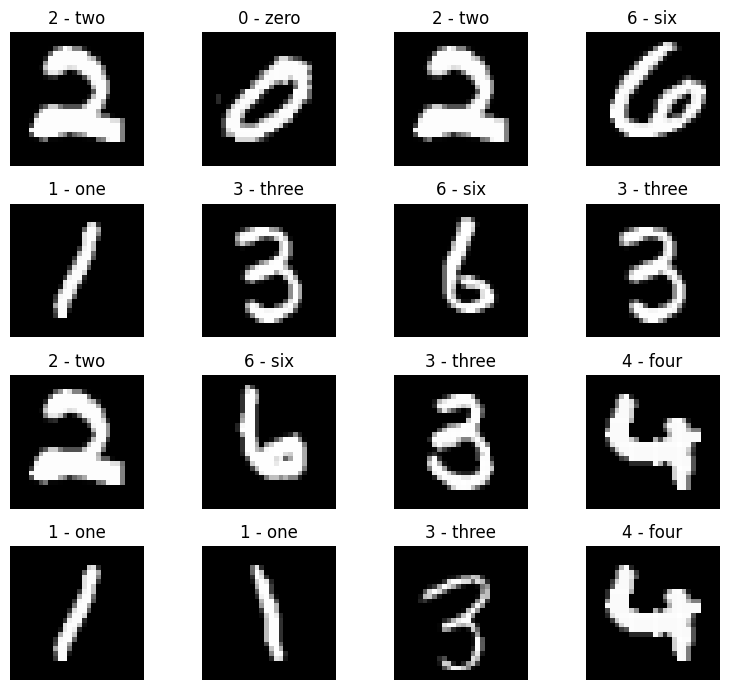

In [56]:
# 5) 데이터 확인
images, labels = next(iter(train_dataset_loader))

# labels map 생성
labels_map = { v:k for k, v in train_dataset.dataset.class_to_idx.items() }

# 이미지 시각화
plt.figure(figsize=(8, 7))
cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    # - torch.randint()는 0부터 high - 1 사이의 정수를 생성
    # - len(images)는 현재 배치에 포함된 이미지 수예요. 예를 들어 BATCH_SIZE = 32이면 len(images)는 32
    # - size = (1,) 생성할 정수의 **개수와 형태(shape)**를 지정, (1,)은 1개의 정수를 담은 1차원 텐서를 의미, 예시: tensor([17]) 결과
    sample_idx = torch.randint(len(images), size=(1, )).item() # 0~31 사이의 정수 중 하나를 랜덤하게 생성
    img, label = images[sample_idx], labels[sample_idx].item() # - 이미지와 라벨 추출

    # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    # img = img * std + mean # 정규화된 이미지 복원
    
    plt.subplot(rows, cols, i)
    # plt.imshow(torch.permute(img, (1, 2, 0))) # (C, H, W) -> (H, W, C) 순서 변경
    plt.imshow(img.squeeze(), cmap='gray') # 흑백 이미지 표시
    plt.title(labels_map[label])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [58]:
# 6) 하이브리드 모델 설계 - CNN → RNN 조합으로 이미지 내 시퀀스적 패턴 학습 가능
class HybridModel_CNN_RNN(nn.Module): # 입력: (B, 1, 28, 28) — MNIST 흑백 이미지
    def __init__(self, in_channels=1, rnn_hidden=128, num_classes=10, dropout_rate=0.3):
        super(HybridModel_CNN_RNN, self).__init__()

        # CNN 부분
        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding=1), # (B, 32, 28, 28)
            nn.ReLU(), # 비선형성 확보
            nn.MaxPool2d(kernel_size=2, stride=2), # (B, 32, 14, 14)

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), # (B, 64, 14, 14)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # (B, 64, 7, 7)

            nn.Dropout(dropout_rate) # 과적합 방지
        )
        
        # RNN 부분: CNN 출력 feature map을 시퀀스로 변환
        self.rnn_input_size = 64 # feature dimension
        self.rnn_seq_len = 7 * 7 # 시퀀스 길이
        self.rnn = nn.LSTM(
            input_size=self.rnn_input_size, # 입력: (B, 49, 64)
            hidden_size=rnn_hidden, # 출력: (B, 49, 128)
            num_layers=2, # 2-layer LSTM으로 깊은 시퀀스 학습
            dropout=dropout_rate, # 과적합 방지
            batch_first=True,
            bidirectional=False
        )
        
        # 최종 분류기
        self.fc = nn.Sequential(
            nn.Linear(rnn_hidden, 64), # LSTM 출력(128) -> 64 차원으로 축소
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, num_classes) # 10개 클래스 분류
        )
    
    def forward(self, x):
        batch_size = x.size(0)
        
        # CNN 통과 - 2개의 Conv + ReLU + MaxPool 블록으로 28×28 → 7×7로 다운샘플링
        x = self.cnn(x)  # (batch_size, 64, 7, 7)

        # CNN 출력 -> 시퀀스 형태로 변환
        x = x.permute(0, 2, 3, 1).contiguous()  # (batch_size, 7, 7, 64), 안전하게 메모리 연속성 확보
        x = x.view(batch_size, self.rnn_seq_len, self.rnn_input_size) # (batch_size, seq_len=49, features=64)
        
        # RNN 통과 - CNN 출력(64×7×7)을 flatten 후 LSTM에 시퀀스 길이 1로 입력
        x, _ = self.rnn(x) # (batch_size, seq_len=49, rnn_hidden=128)
        x = x[:, -1, :]  # 마지막 시퀀스 출력 사용 (batch_size, rnn_hidden=128)
        
        # 최종 분류 - LSTM의 마지막 hidden state를 받아 10개 클래스 분류
        x = self.fc(x) # (batch_size, num_classes=10)
        return x

In [59]:
# 7) EarlyStopping 클래스 정의
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0, path='./models/model_hybrid_mnist.pt'):
        self.patience = patience          # 개선되지 않아도 기다릴 epoch 수
        self.verbose = verbose            # 개선 시 출력 여부
        self.counter = 0                  # 개선되지 않은 epoch 수
        self.best_score = None            # 최고 성능 점수
        self.early_stop = False           # 중단 여부
        self.val_loss_min = float('inf')  # 최소 validation loss
        self.delta = delta                # 개선 최소 차이
        self.path = path                  # 모델 저장 경로

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Validation loss가 감소하면 모델 저장'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [60]:
# 8) model, loss, optimizer 객체 생성 및 StepLR 스케줄러 정의
#  Model 객체 생성
model = HybridModel_CNN_RNN(in_channels=1, rnn_hidden=128, num_classes=10).to(DEVICE)
# loss function
loss_function = nn.CrossEntropyLoss() # Softmax() 함수 포함되어 있음
# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Model 정보
print(model)

HybridModel_CNN_RNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.3, inplace=False)
  )
  (rnn): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [61]:
# 9) Model train 함수
def model_train(dataloader, model, loss_function, optimizer):
    model.train() # 확습모드

    train_loss_sum = 0 # train loss 합
    train_correct = 0 # train 맞춘 개수
    train_total = 0 # train 전체 개수
    total_train_batch = len(dataloader) # 전체 배치 개수
    for images, labels in dataloader: # dataloader에서 배치 단위로 이미지와 라벨 추출        
        x_train = images.to(DEVICE) # GPU로 데이터 전송
        y_train = labels.to(DEVICE)
        
        outputs = model(x_train) # 모델 예측
        loss = loss_function(outputs, y_train) # 손실함수 계산

        # 오차역전파
        optimizer.zero_grad() # 미분 연산 초기화
        loss.backward() # 미분 연산
        optimizer.step() # 미분 연산 후 가중치 바이어스 파라미터 업데이트

        train_loss_sum += loss.item() # 오차 누적
        train_total += y_train.size(0) # 배치 내 샘플 개수 누적
        train_correct += (torch.argmax(outputs, dim=1) == y_train).sum().item() # - argmax로 예측값과 실제값 비교 후 맞춘 개수 누적
        
    train_avg_loss = train_loss_sum / total_train_batch # 평균 오차 계산
    train_avg_accuracy = 100 * train_correct / train_total # 평균 정확도 계산

    return train_avg_loss, train_avg_accuracy

In [62]:
# 10) Model evaluate 함수
def model_evaluate(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        val_loss_sum = 0
        val_correct = 0
        val_total = 0
        total_val_batch = len(dataloader)
        for images, labels in dataloader:            
            x_val = images.to(DEVICE)
            y_val = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_val)

            # 손실함수값 계산
            loss = loss_function(outputs, y_val)

            val_loss_sum += loss.item()
            val_total += y_val.size(0)
            val_correct += (torch.argmax(outputs, dim=1) == y_val).sum().item()

        val_avg_loss = val_loss_sum / total_val_batch # 평균 오차 계산
        val_avg_accuracy = 100 * val_correct / val_total # 평균 정확도 계산

        return val_avg_loss, val_avg_accuracy

In [63]:
# 11) Model test 함수
def model_test(dataloader, model, loss_function):
    model.eval() # 추론모드

    with torch.no_grad(): # 미분 연산 하지 않음
        test_loss_sum = 0
        test_correct = 0
        test_total = 0
        total_test_batch = len(dataloader)
        for images, labels in dataloader:            
            x_test = images.to(DEVICE)
            y_test = labels.to(DEVICE)

            # 모델 예측값 게산
            outputs = model(x_test)

            # 손실함수값 계산
            loss = loss_function(outputs, y_test)

            test_loss_sum += loss.item()
            test_total += y_test.size(0)
            test_correct += (torch.argmax(outputs, dim=1) == y_test).sum().item()
            
        test_avg_loss = test_loss_sum / total_test_batch
        test_avg_accuracy = 100 * test_correct / test_total

        print('accuracy = ', test_avg_accuracy, ', loss = ', test_avg_loss)
        return test_avg_loss, test_avg_accuracy


In [65]:
# 12) Model 학습 
train_loss_list = []
train_accuracy_list = []
val_loss_list = []
val_accuracy_list = []
start_time = datetime.now()
early_stopping = EarlyStopping(patience=5, verbose=True)
EPOCHS = 20 # cpu 사용시 에폭 3배이상 낮게 설정

for epoch in range(EPOCHS):
    # train
    train_avg_loss, train_avg_accuracy = model_train(dataloader=train_dataset_loader, model=model, loss_function=loss_function, optimizer=optimizer)
    train_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_avg_accuracy)

    # evaluate
    val_avg_loss, val_avg_accuracy = model_evaluate(dataloader=validation_dataset_loader, model=model, loss_function=loss_function)
    val_loss_list.append(val_avg_loss)
    val_accuracy_list.append(val_avg_accuracy)

    # early stopping
    early_stopping(val_loss=val_avg_loss, model=model)
    
    # print
    print(
        'epoch : ', '%02d' % (epoch + 1),
        'train loss = ', '{:4f}'.format(train_avg_loss), ', train acc = ', '{:4f}'.format(train_avg_accuracy),
        'val loss = ', '{:4f}'.format(val_avg_loss), ', val acc = ', '{:4f}'.format(val_avg_accuracy)
    )

    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# time
end_time = datetime.now()
print('elapsed time => ', end_time -start_time)

Validation loss decreased (inf → 0.047484). Saving model...
epoch :  01 train loss =  0.069013 , train acc =  98.129167 val loss =  0.047484 , val acc =  98.725000
EarlyStopping counter: 1 out of 5
epoch :  02 train loss =  0.063272 , train acc =  98.243750 val loss =  0.059285 , val acc =  98.400000
Validation loss decreased (0.047484 → 0.042967). Saving model...
epoch :  03 train loss =  0.060448 , train acc =  98.285417 val loss =  0.042967 , val acc =  98.958333
EarlyStopping counter: 1 out of 5
epoch :  04 train loss =  0.056155 , train acc =  98.404167 val loss =  0.052394 , val acc =  98.666667
Validation loss decreased (0.042967 → 0.042617). Saving model...
epoch :  05 train loss =  0.050995 , train acc =  98.512500 val loss =  0.042617 , val acc =  98.766667
EarlyStopping counter: 1 out of 5
epoch :  06 train loss =  0.050228 , train acc =  98.510417 val loss =  0.049967 , val acc =  98.541667
Validation loss decreased (0.042617 → 0.032414). Saving model...
epoch :  07 train l

In [66]:
# 13) 테스트 데이터셋 정확도, 오차 테스트
model_test(dataloader=test_dataset_loader, model=model, loss_function=loss_function)

accuracy =  96.98 , loss =  0.12562800837031246


(0.12562800837031246, 96.98)

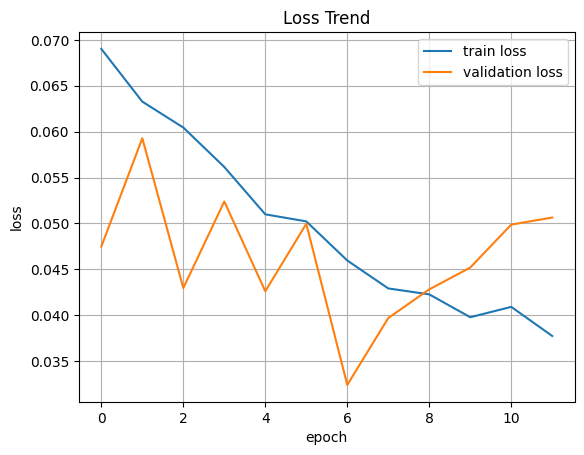

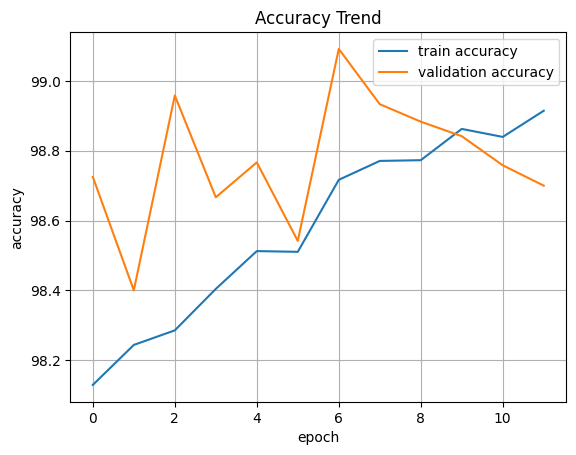

In [67]:
# 14) 시각화 - 손실함수
plt.title('Loss Trend')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(train_loss_list, label='train loss')
plt.plot(val_loss_list, label='validation loss')
plt.grid()
plt.legend(loc='best')
plt.show()

# 시각화 - 정확도
plt.title('Accuracy Trend')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(train_accuracy_list, label='train accuracy')
plt.plot(val_accuracy_list, label='validation accuracy')
plt.grid()
plt.legend(loc='best')
plt.show()

In [68]:
# 15) Save the model checkpoint
os.makedirs('./models', exist_ok=True)
torch.save(model.state_dict(), './models/model_hybrid_mnist.pt')

{0: '0 - zero', 1: '1 - one', 2: '2 - two', 3: '3 - three', 4: '4 - four', 5: '5 - five', 6: '6 - six', 7: '7 - seven', 8: '8 - eight', 9: '9 - nine'}


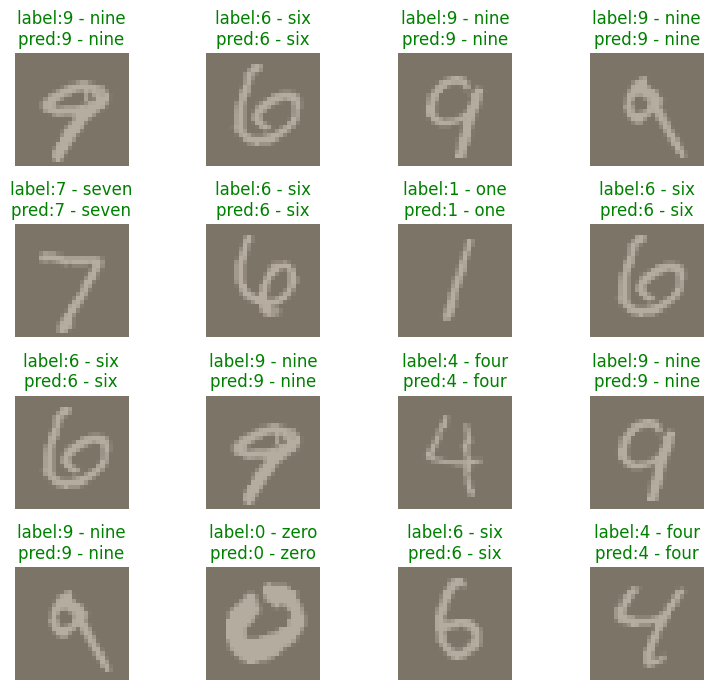

In [70]:
# 16) 테스트 - 모델 추론 및 예측값 추출
BATCH_SIZE = 32

# test dataloaer 생성
test_image_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_images, test_labels = next(iter(test_image_loader)) # 1개 배치 추출

x_test = test_images.to(DEVICE) # - GPU로 데이터 이동
y_test = test_labels.to(DEVICE)

outputs = model(x_test) # 모델 추론
_, preds = torch.max(outputs, 1) # 모델 예측값 추출

# 시각화 - 추론 및 정답 비교

# labels map 생성 - train_dataset 에서 정답 label map을 생성
labels_map = { v : k for k, v in train_dataset.dataset.class_to_idx.items() }
print(labels_map)

# 시각화
plt.figure(figsize=(8, 7))

cols, rows = 4, 4

for i in range(1, cols * rows + 1):
    plt.subplot(rows, cols, i)

    # torch.randint()를 통한 1개의 index 추출
    sample_idx = torch.randint(len(x_test), size=(1,)).item()
    
    # test dataloder에서 image, label, pred 값을 추출하여 시각화 비교
    img, label, pred = test_images[sample_idx], test_labels[sample_idx].item(), preds[sample_idx].item()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1) # 평균 값
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) # 표준편차 값
    img = img * std + mean # 정규화된 이미지 복원
    img = img.clamp(0, 1) # 0~1 사이의 값으로 클램핑

    correct = (label == pred) # 정답 여부
    title_color = 'green' if correct else 'red' # 정답이면 녹색, 오답이면 빨간색
    plt.title('label:' + labels_map[label] + '\npred:' + labels_map[pred], color=title_color) # - 정답이면 녹색, 오답이면 빨간색 타이틀 출력
    plt.imshow(torch.permute(img, (1, 2, 0))) # 본래 이미지 shape (3, 224, 224) -> 시각화 하기 위해서 (224, 224, 3) 변환
    plt.axis('off')
plt.tight_layout()
plt.show()